In [1]:
!pip install -U tensorflow-addons

## Imports

In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML
from itertools import product
import numpy as np
import random

## Constants

In [3]:
# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)


# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (15, 120, 160, 1)
TIME_LEN = INPUT_SHAPE[0]
OUTPUT_SHAPE = (120, 160, 1)
NUM_CLASSES = 6

# OPTIMIZER
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5

# PRETRAINING
EPOCHS = 500

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
CROP_SIZE = 100
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 256
DEC_PROJECTION_DIM = 128
ENC_NUM_HEADS = 4
ENC_LAYERS = 8
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    4  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

## Load Datasets

In [4]:
"""Returns a Dataset for reading from a SageMaker PipeMode channel."""
features = {
    'video': tf.io.FixedLenFeature([], tf.string),
    'frame': tf.io.FixedLenFeature([], tf.string),
}

def parse(record):

    parsed = tf.io.parse_single_example(
        serialized=record,
        features=features
    )
    video_raw = parsed['video']
    video_raw = tf.io.decode_raw(video_raw, tf.uint8)
    video_raw = tf.cast(video_raw, tf.float32)

    frame_raw = parsed['frame']
    frame_raw = tf.io.decode_raw(frame_raw, tf.uint8)
    frame_raw = tf.cast(frame_raw, tf.float32)
    
    video_raw = tf.reshape(video_raw, INPUT_SHAPE)
    frame_raw = tf.reshape(frame_raw, OUTPUT_SHAPE)

    return video_raw, frame_raw

In [5]:
files = tf.data.Dataset.list_files("datasets/KTH_tfrecords/training/*.tfrecord")
train_ds = files.interleave(
    lambda x: tf.data.TFRecordDataset(x).prefetch(100),
    cycle_length=8
)
train_ds = train_ds.map(parse, num_parallel_calls=AUTO)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)


files = tf.data.Dataset.list_files("datasets/KTH_tfrecords/validation/*.tfrecord")
val_ds = files.interleave(
    lambda x: tf.data.TFRecordDataset(x).prefetch(100),
    cycle_length=8
)
val_ds = val_ds.map(parse, num_parallel_calls=AUTO)
val_ds = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

# filenames = sorted(glob.glob("datasets/KTH_tfrecords/testing/*.tfrecord"))
# test_ds = tf.data.TFRecordDataset(filenames)
# test_ds = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

2022-05-10 00:31:30.132539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 00:31:30.143554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 00:31:30.144215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 00:31:30.145475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Simple training augmentations

In [6]:
def left_right_flip(video, frame):
    '''
    Performs tf.image.flip_left_right on entire list of video frames.
    Work around since the random selection must be consistent for entire video
    :param video: Tensor constaining video frames (N,H,W,3)
    :return: video: Tensor constaining video frames left-right flipped (N,H,W,3)
    '''
    video_list = tf.unstack(video, axis=1)
    for i in range(len(video_list)):
        video_list[i] = tf.image.flip_left_right(video_list[i])
    video = tf.stack(video_list, axis=1)
    frame = tf.image.flip_left_right(frame)
    return video, frame

def random_crop(video, frame, size):
    # (T, H, W, 1)
    shape = tf.shape(video)
    size = tf.convert_to_tensor(size, dtype=shape.dtype)
    h_diff = shape[2] - size[1]
    w_diff = shape[3] - size[0]

    dtype = shape.dtype
    rands = tf.random.uniform(shape=[2], minval=0, maxval=dtype.max, dtype=dtype)
    h_start = tf.cast(rands[0] % (h_diff + 1), dtype)
    w_start = tf.cast(rands[1] % (w_diff + 1), dtype)
    size = tf.cast(size, tf.int32)
    video_list = tf.unstack(video, axis=1)
    for i in range(len(video_list)):
        video_list[i] = tf.image.crop_to_bounding_box(
            video_list[i],
            h_start, w_start,
            size[1], size[0]
        )
    video = tf.stack(video_list, axis=1)
    frame = tf.image.crop_to_bounding_box(
        frame,
        h_start, w_start,
        size[1], size[0]
    )
    return video, frame

def resize(video, frame, size):
    video_list = tf.unstack(video, axis=1)
    for i in range(len(video_list)):
        video_list[i] = tf.image.resize(
            video_list[i],
            size
        )
    video = tf.stack(video_list, axis=1)
    frame = tf.image.resize(frame, size)
    return video, frame
        

class TrainingPreprocessing(tf.keras.layers.Layer):
    def __init__(self):
        super(TrainingPreprocessing, self).__init__()

    def call(self, data):
        video, frame = data
        video, frame = random_crop(video, frame, (CROP_SIZE, CROP_SIZE))
        video, frame = resize(video, frame, (IMAGE_SIZE, IMAGE_SIZE))
        sample = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32)
        option = tf.less(sample, 0.5)
        video, frame = tf.cond(
            option,
            lambda: left_right_flip(video, frame),
            lambda: (video, frame)
        )
        video = tf.cast(video, tf.float32) * (1 / 255.)
        frame = tf.cast(frame, tf.float32) * (1 / 255.)
        return video, frame


class TestingPreprocessing(tf.keras.layers.Layer):
    def __init__(self):
        super(TestingPreprocessing, self).__init__()

    def call(self, data):
        video, frame = data
        video, frame = resize(video, frame, (IMAGE_SIZE, IMAGE_SIZE))
        video = tf.cast(video, tf.float32) * (1 / 255.)
        frame = tf.cast(frame, tf.float32) * (1 / 255.)
        return video, frame
    

def get_train_augmentation_model():
    inputs = keras.Input(shape=INPUT_SHAPE, name="Original Video")
    output = keras.Input(shape=OUTPUT_SHAPE, name="Next frame")
    [aug, out] = TrainingPreprocessing()([inputs, output])
    return keras.Model(inputs=[inputs, output], outputs=[aug, out], name="train_data_augmentation")


def get_test_augmentation_model():
    inputs = keras.Input(shape=INPUT_SHAPE, name="Original Video")
    output = keras.Input(shape=OUTPUT_SHAPE, name="Next frame")
    [aug, out] = TestingPreprocessing()([inputs, output])
    
    return keras.Model(inputs=[inputs, output], outputs=[aug, out], name="test_data_augmentation")

## A layer for extracting patches from images

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, time_len=TIME_LEN, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.time_len = time_len
        self.resize = layers.Reshape((-1, patch_size * patch_size * 1))

    def call(self, data):
        video, frame = data
        # Create patches from the input images
        video_list = tf.unstack(video, axis=1)
        for i in range(len(video_list)):
            patches = tf.image.extract_patches(
                images=video_list[i],
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding="VALID",
            )

            # Reshape the patches to (batch, num_patches, patch_area) and return it.
            video_list[i] = self.resize(patches)
        video = tf.stack(video_list, axis=1)
        frame = tf.image.extract_patches(
            images=frame,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return video, frame

    def show_patched_image(self, video, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        n = int(np.sqrt(patches.shape[-2]))
        print(f"Index selected: {idx}.")

        fig = plt.figure()
        gs = gridspec.GridSpec(n, 2 * n, figure=fig, hspace=0.08, wspace=0.1)
        ax = fig.add_subplot(gs[:n, n: 2*n])
        big_im = ax.imshow(video[idx, 0, :, :], cmap='gray')
        ax.set_axis_off()

        grid = list(product(range(n), range(n)))
        patch_list = []
        norm = matplotlib.colors.NoNorm()
        # cm = matplotlib.cm.ScalarMappable(norm, cmap='Greys')
        for i in range(patches.shape[-2]):
            ax = fig.add_subplot(gs[grid[i][0], grid[i][1]])
            patch_img = tf.reshape(
                patches[idx, 0, i, :],
                (self.patch_size, self.patch_size)
            )
            im = ax.imshow(patch_img, cmap='Greys_r', norm=norm)
            patch_list.append(im)
            ax.set_axis_off()
        plt.close()
        def init():
            big_im.set_data(video[idx,0,:,:])
            for i, im in enumerate(patch_list):
                patch_img = tf.reshape(
                    patches[idx, 0, i, :],
                    (self.patch_size, self.patch_size)
                )
                im.set_data(patch_img)
        def animate(j):
            big_im.set_data(video[idx,j,:,:])
            for i, im in enumerate(patch_list):
                patch_img = tf.reshape(
                    patches[idx, j, i, :],
                    (self.patch_size, self.patch_size)
                )
                im.set_data(patch_img)
        anim = animation.FuncAnimation(
            fig,
            animate,
            init_func=init,
            frames=video.shape[1],
            interval=50
        )
        return anim, idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[-2]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (self.time_len, num_patches, self.patch_size, self.patch_size))
        video = []
        for i in range(self.time_len):
            rows = tf.split(patch[i], n, axis=0)
            rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
            reconstructed = tf.concat(rows, axis=0)
            video.append(reconstructed)
        return tf.stack(video, axis=0)

In [8]:
videos, next_frames = next(iter(train_ds))
print(f"Videos: {videos.get_shape()}")
print(f"Next frame: {next_frames.get_shape()}")
# Augment the images.
augmentation_model = get_train_augmentation_model()
aug_videos, aug_next_frames = augmentation_model([videos, next_frames])
print(f"Videos: {aug_videos.get_shape()}")
print(f"Next frame: {aug_next_frames.get_shape()}")
patch_layer = Patches()

# Get the patches from the batched images.
vid_patches, frame_patches = patch_layer([aug_videos, aug_next_frames])

# # Now pass the images and the corresponding patches
# # to the `show_patched_image` method.
anim, random_index = patch_layer.show_patched_image(aug_videos, vid_patches)
HTML(anim.to_html5_video())

Videos: (256, 15, 120, 160, 1)
Next frame: (256, 120, 160, 1)
Videos: (256, 15, 48, 48, 1)
Next frame: (256, 48, 48, 1)
Index selected: 102.


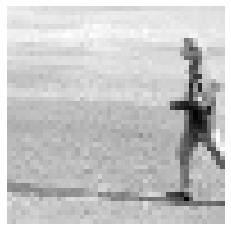

In [9]:
fig, ax = plt.subplots()
ax.imshow(aug_next_frames[random_index, :, :], cmap='gray')
ax.set_axis_off()
plt.show()

In [10]:
# # Chose the same chose image and try reconstructing the patches
# # into the original image.
video = patch_layer.reconstruct_from_patch(vid_patches[random_index])
fig, ax = plt.subplots()
big_im = ax.imshow(video[0, :, :], cmap='gray')
ax.set_axis_off()
plt.close()

def init():
    big_im.set_data(video[0,:,:])
def animate(j):
    big_im.set_data(video[j,:,:])
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=video.shape[0],
    interval=50
)
HTML(anim.to_html5_video())

## Patch encoding with masking

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([15, 1, patch_size * patch_size]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_frames, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        # self.projection = keras.Sequential([
        #     layers.Permute((2, 1, 3)),
        #     layers.Reshape((-1, self.num_frames*self.patch_area)),
        #     layers.Dense(units=self.projection_dim)
        # ], name="projection_model")

        self.projection = layers.GRU(units=self.projection_dim)
        # self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # patches: (B, T, N, ps*ps)
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches. (GRU)
        projection = tf.unstack(patches, axis=-2)
        for i in range(len(projection)):
            projection[i] = self.projection(projection[i])
        # (B, num_patches, projection_dim)
        projection = tf.stack(projection, axis=1)
        # Embed the patches. (LINEAR)
        # projection = self.projection(patches)
        patch_embeddings = (
            projection + pos_embeddings
        )  # (B, num_patches, projection_dim)
        
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            # mask_tokens: (T, ps*ps)
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=1)
            # mask_tokens = tf.repeat(mask_tokens[tf.newaxis, ...], repeats=self.num_frames, axis=0)
            # mask_tokens = (mask_numbers, projection_dim) 
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )
            # Embed the tokens (GRU)
            mask_tokens = tf.unstack(mask_tokens, axis=-2)
            for i in range(len(mask_tokens)):
                mask_tokens[i] = self.projection(mask_tokens[i])
            # (B, num_patches, projection_dim)
            mask_tokens = tf.stack(mask_tokens, axis=1)
            # Embed the tokens (LINEAR)
            # mask_tokens = self.projection(mask_tokens)
            # mask_tokens = (1, projection_dim)
            # Get the masked embeddings for the tokens.
            masked_embeddings = mask_tokens + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        for i in range(unmask_index.shape[0]):
            new_patch[:, unmask_index[i], ...] = patch[:, unmask_index[i], ...]
        return new_patch, idx

In [12]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=vid_patches)

# Show a maksed patch image.
patch, random_index = patch_encoder.generate_masked_image(vid_patches, unmask_indices)
video = patch_layer.reconstruct_from_patch(patch)
fig, ax = plt.subplots()
norm = matplotlib.colors.NoNorm()
big_im = ax.imshow(video[0, :, :], cmap='gray', norm=norm)
ax.set_axis_off()
plt.close()

def init():
    big_im.set_data(video[0,:,:])
def animate(j):
    big_im.set_data(video[j,:,:])
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=video.shape[0],
    interval=50
)
HTML(anim.to_html5_video())

2022-05-10 00:31:38.367126: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


In [13]:
# # into the original image.
video = patch_layer.reconstruct_from_patch(vid_patches[random_index])
fig, ax = plt.subplots()
big_im = ax.imshow(video[0, :, :], cmap='gray')
ax.set_axis_off()
plt.close()

def init():
    big_im.set_data(video[0,:,:])
def animate(j):
    big_im.set_data(video[j,:,:])
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=video.shape[0],
    interval=50
)
HTML(anim.to_html5_video())

## MLP

In [14]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## MAE encoder

In [15]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

## MAE decoder

In [16]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size, activation='sigmoid')(x) # tanh sigmoid
    outputs = layers.Reshape((image_size, image_size, 1))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

## MAE trainer

In [17]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
        self.resize = layers.Reshape((-1, self.patch_layer.patch_size * self.patch_layer.patch_size * 1))

    def calculate_loss(self, data, test=False):
        videos, next_frames = data
        # Augment the input images.
        if test:
            aug_videos, next_frame = self.test_augmentation_model([videos, next_frames])
        else:
            aug_videos, next_frame = self.train_augmentation_model([videos, next_frames])

        # Patch the augmented images.
        # patches = self.patch_layer(aug_videos)
        vid_patches, frame_patches =  self.patch_layer([aug_videos, next_frame])

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(vid_patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = tf.image.extract_patches(
            images=decoder_outputs,
            sizes=[1, self.patch_layer.patch_size, self.patch_layer.patch_size, 1],
            strides=[1, self.patch_layer.patch_size, self.patch_layer.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        
        loss_output = self.resize(decoder_patches)
        loss_patch = self.resize(frame_patches)
        
        # loss_patch = tf.gather(
        #     loss_patch,
        #     mask_indices,
        #     axis=1,
        #     batch_dims=1
        # )
        # loss_output = tf.gather(
        #     loss_output,
        #     mask_indices,
        #     axis=1,
        #     batch_dims=1
        # )
        # Compute the total loss.
        # Calculate loss on patches
        # total_loss = self.compiled_loss(loss_patch, loss_output)
        # # Calculate loss on all outputs
        total_loss = self.compiled_loss(frame_patches, decoder_patches)

        return total_loss, loss_patch, loss_output
        # return total_loss

    def train_step(self, data):
        videos, next_frames = data
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss([videos, next_frames])
            # total_loss = self.calculate_loss([videos, next_frames])

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        # import pdb
        # pdb.set_trace()
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        videos, next_frames = data
        total_loss, loss_patch, loss_output = self.calculate_loss([videos, next_frames], test=True)
        # total_loss = self.calculate_loss([videos, next_frames], test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

## Model INIT

In [18]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Train Monitor Callback

In [19]:
videos, next_frames = next(iter(val_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_aug_vids, test_aug_frames = self.model.test_augmentation_model([videos, next_frames])
            test_vid_patches, test_frame_patches = self.model.patch_layer([test_aug_vids, test_aug_frames])
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_vid_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_vid_patches, test_unmask_indices
            )
            test_video = patch_layer.reconstruct_from_patch(test_masked_patch)
            print(f"\nIdx chosen: {idx}")
            original_frame = test_aug_frames[idx]
            # print(original_frame.min(),original_frame.max()) 

            reconstructed_frame = test_decoder_outputs[idx]
            # print(reconstructed_frame.min(),reconstructed_frame.max())

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_frame, cmap='gray')
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(test_video[-1, :, :], cmap='gray')
            ax[1].set_title(f"Masked: {epoch:03d}")

            
            ax[2].imshow(reconstructed_frame, cmap='gray')
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

## LR scheduler

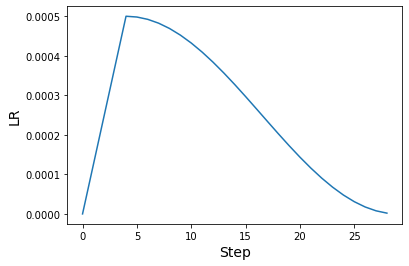

In [20]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(list(train_ds)) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='models/KTH/',
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

train_callbacks = [
    TrainMonitor(epoch_interval=5),
    # model_checkpoint_callback
]

Epoch 1/500
     15/Unknown - 21s 1s/step - loss: 0.0951 - mae: 0.2310
Idx chosen: 92


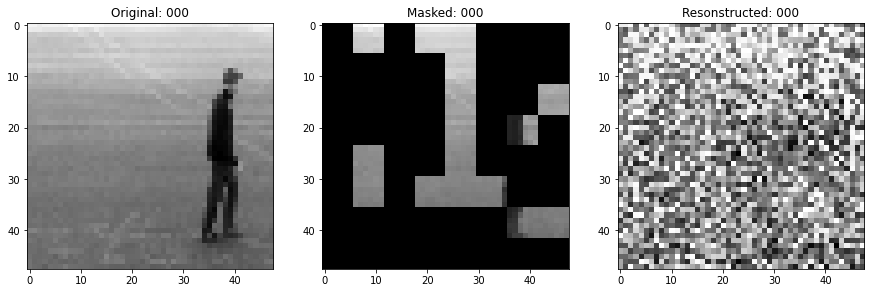

15/15 [==============================] - 31s 2s/step - loss: 0.0951 - mae: 0.2310 - val_loss: 0.0954 - val_mae: 0.2552
Epoch 2/500
15/15 [==============================] - 29s 2s/step - loss: 0.0392 - mae: 0.1379 - val_loss: 0.0444 - val_mae: 0.1659
Epoch 3/500
15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0445 - val_mae: 0.1662
Epoch 4/500
15/15 [==============================] - 29s 2s/step - loss: 0.0295 - mae: 0.1138 - val_loss: 0.0444 - val_mae: 0.1661
Epoch 5/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1141 - val_loss: 0.0444 - val_mae: 0.1659
Epoch 6/500
15/15 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1135
Idx chosen: 14


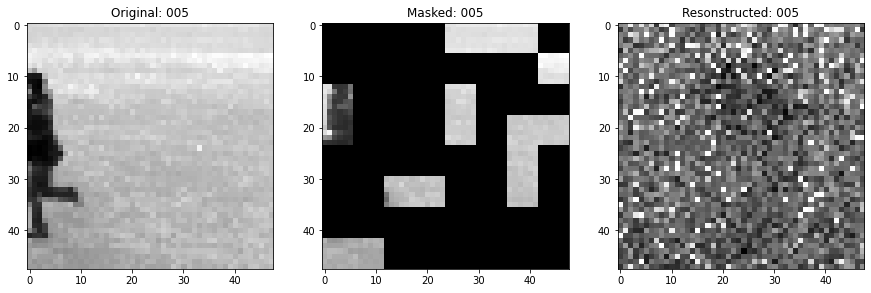

15/15 [==============================] - 29s 2s/step - loss: 0.0294 - mae: 0.1135 - val_loss: 0.0444 - val_mae: 0.1660
Epoch 7/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1142 - val_loss: 0.0444 - val_mae: 0.1658
Epoch 8/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1143 - val_loss: 0.0442 - val_mae: 0.1654
Epoch 9/500
15/15 [==============================] - 28s 2s/step - loss: 0.0299 - mae: 0.1148 - val_loss: 0.0442 - val_mae: 0.1654
Epoch 10/500
15/15 [==============================] - 29s 2s/step - loss: 0.0299 - mae: 0.1145 - val_loss: 0.0442 - val_mae: 0.1653
Epoch 11/500
15/15 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.1143
Idx chosen: 106


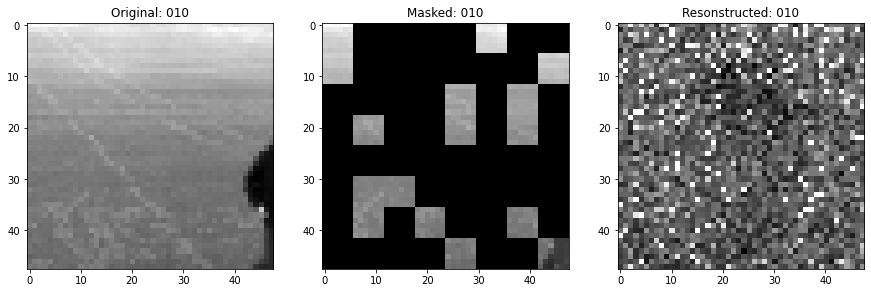

15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0441 - val_mae: 0.1651
Epoch 12/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1145 - val_loss: 0.0441 - val_mae: 0.1652
Epoch 13/500
15/15 [==============================] - 29s 2s/step - loss: 0.0302 - mae: 0.1150 - val_loss: 0.0440 - val_mae: 0.1647
Epoch 14/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1143 - val_loss: 0.0440 - val_mae: 0.1649
Epoch 15/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1141 - val_loss: 0.0439 - val_mae: 0.1646
Epoch 16/500
15/15 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.1142
Idx chosen: 71


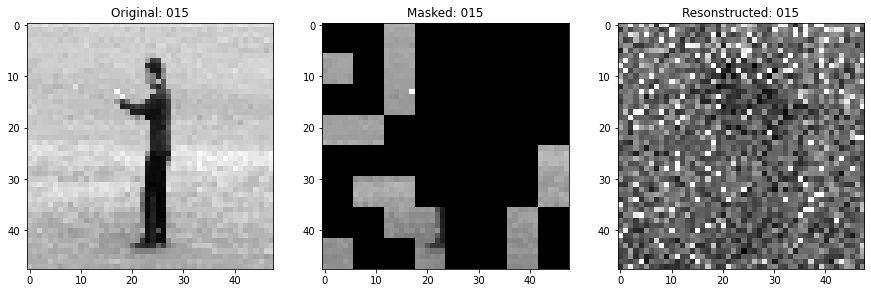

15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1142 - val_loss: 0.0439 - val_mae: 0.1645
Epoch 17/500
15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1142 - val_loss: 0.0439 - val_mae: 0.1646
Epoch 18/500
15/15 [==============================] - 29s 2s/step - loss: 0.0300 - mae: 0.1149 - val_loss: 0.0438 - val_mae: 0.1642
Epoch 19/500
15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0439 - val_mae: 0.1645
Epoch 20/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0438 - val_mae: 0.1642
Epoch 21/500
15/15 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.1141
Idx chosen: 188


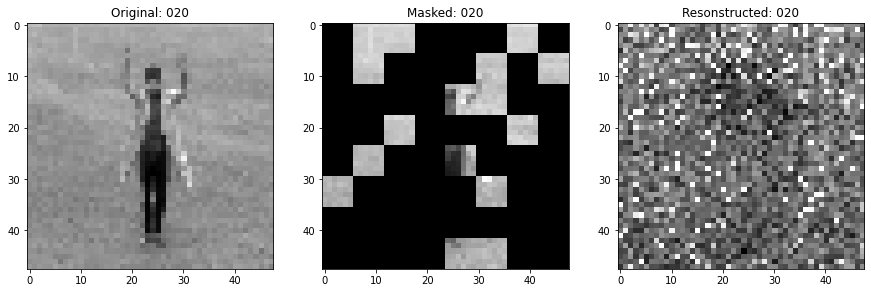

15/15 [==============================] - 30s 2s/step - loss: 0.0297 - mae: 0.1141 - val_loss: 0.0437 - val_mae: 0.1642
Epoch 22/500
15/15 [==============================] - 29s 2s/step - loss: 0.0302 - mae: 0.1152 - val_loss: 0.0438 - val_mae: 0.1642
Epoch 23/500
15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0436 - val_mae: 0.1638
Epoch 24/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0437 - val_mae: 0.1638
Epoch 25/500
15/15 [==============================] - 29s 2s/step - loss: 0.0299 - mae: 0.1145 - val_loss: 0.0435 - val_mae: 0.1634
Epoch 26/500
15/15 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.1144
Idx chosen: 20


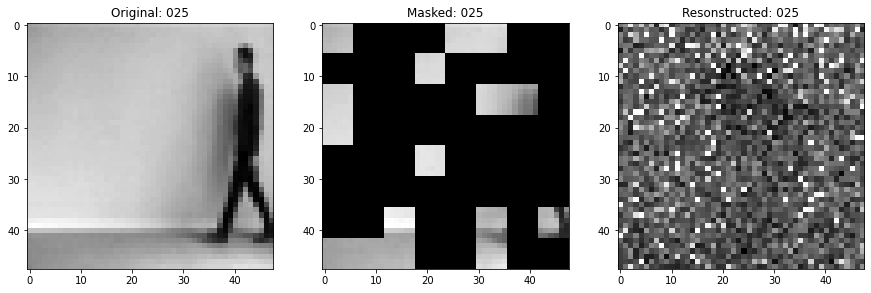

15/15 [==============================] - 30s 2s/step - loss: 0.0298 - mae: 0.1144 - val_loss: 0.0435 - val_mae: 0.1635
Epoch 27/500
15/15 [==============================] - 29s 2s/step - loss: 0.0298 - mae: 0.1145 - val_loss: 0.0436 - val_mae: 0.1635
Epoch 28/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1142 - val_loss: 0.0435 - val_mae: 0.1634
Epoch 29/500
15/15 [==============================] - 28s 2s/step - loss: 0.0293 - mae: 0.1132 - val_loss: 0.0435 - val_mae: 0.1632
Epoch 30/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0435 - val_mae: 0.1632
Epoch 31/500
15/15 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.1143
Idx chosen: 102


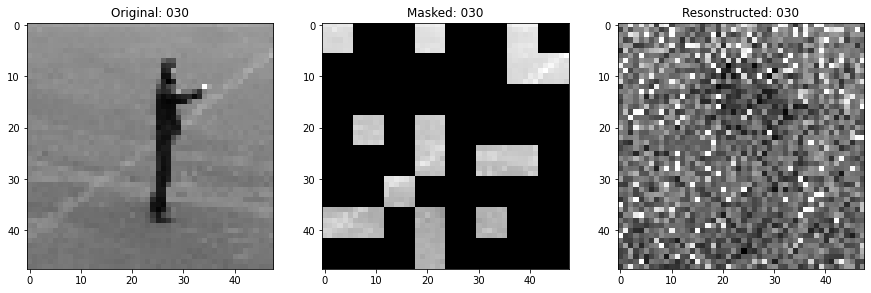

15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1143 - val_loss: 0.0434 - val_mae: 0.1631
Epoch 32/500
15/15 [==============================] - 28s 2s/step - loss: 0.0298 - mae: 0.1144 - val_loss: 0.0434 - val_mae: 0.1630
Epoch 33/500
15/15 [==============================] - 28s 2s/step - loss: 0.0297 - mae: 0.1141 - val_loss: 0.0434 - val_mae: 0.1630
Epoch 34/500
15/15 [==============================] - 28s 2s/step - loss: 0.0298 - mae: 0.1144 - val_loss: 0.0434 - val_mae: 0.1629
Epoch 35/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0433 - val_mae: 0.1627
Epoch 36/500
15/15 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.1149
Idx chosen: 121


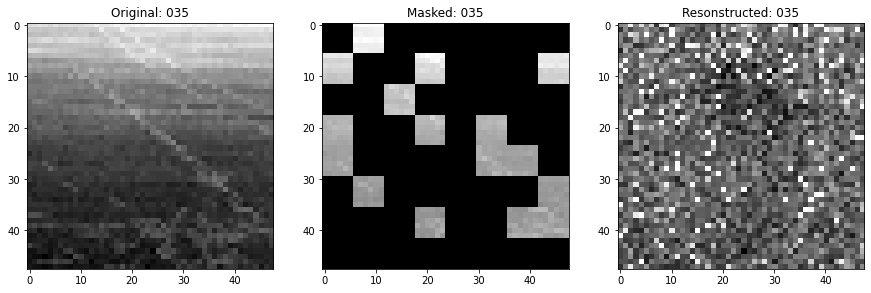

15/15 [==============================] - 29s 2s/step - loss: 0.0300 - mae: 0.1149 - val_loss: 0.0432 - val_mae: 0.1626
Epoch 37/500
15/15 [==============================] - 28s 2s/step - loss: 0.0298 - mae: 0.1141 - val_loss: 0.0432 - val_mae: 0.1624
Epoch 38/500
15/15 [==============================] - 28s 2s/step - loss: 0.0294 - mae: 0.1133 - val_loss: 0.0433 - val_mae: 0.1627
Epoch 39/500
15/15 [==============================] - 30s 2s/step - loss: 0.0300 - mae: 0.1147 - val_loss: 0.0431 - val_mae: 0.1623
Epoch 40/500
15/15 [==============================] - 28s 2s/step - loss: 0.0297 - mae: 0.1140 - val_loss: 0.0430 - val_mae: 0.1620
Epoch 41/500
15/15 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1136
Idx chosen: 210


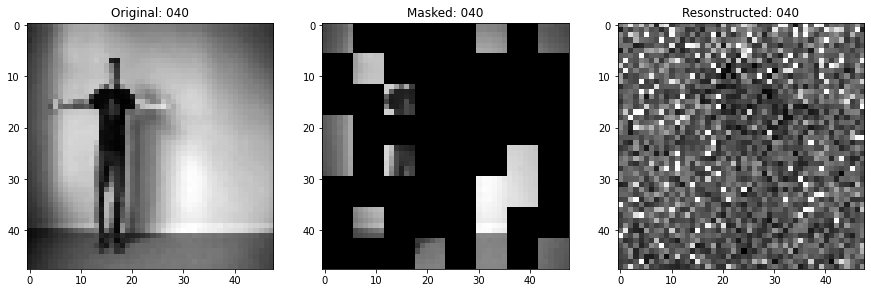

15/15 [==============================] - 29s 2s/step - loss: 0.0294 - mae: 0.1136 - val_loss: 0.0430 - val_mae: 0.1619
Epoch 42/500
15/15 [==============================] - 28s 2s/step - loss: 0.0295 - mae: 0.1136 - val_loss: 0.0430 - val_mae: 0.1618
Epoch 43/500
15/15 [==============================] - 29s 2s/step - loss: 0.0295 - mae: 0.1137 - val_loss: 0.0430 - val_mae: 0.1619
Epoch 44/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1138 - val_loss: 0.0429 - val_mae: 0.1615
Epoch 45/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0429 - val_mae: 0.1616
Epoch 46/500
15/15 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1135
Idx chosen: 214


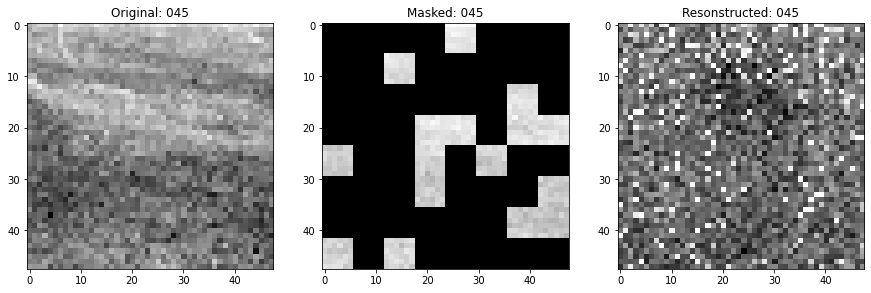

15/15 [==============================] - 29s 2s/step - loss: 0.0294 - mae: 0.1135 - val_loss: 0.0428 - val_mae: 0.1614
Epoch 47/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1141 - val_loss: 0.0428 - val_mae: 0.1614
Epoch 48/500
15/15 [==============================] - 28s 2s/step - loss: 0.0293 - mae: 0.1133 - val_loss: 0.0428 - val_mae: 0.1612
Epoch 49/500
15/15 [==============================] - 28s 2s/step - loss: 0.0295 - mae: 0.1136 - val_loss: 0.0427 - val_mae: 0.1611
Epoch 50/500
15/15 [==============================] - 28s 2s/step - loss: 0.0297 - mae: 0.1140 - val_loss: 0.0428 - val_mae: 0.1613
Epoch 51/500
15/15 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.1143
Idx chosen: 74


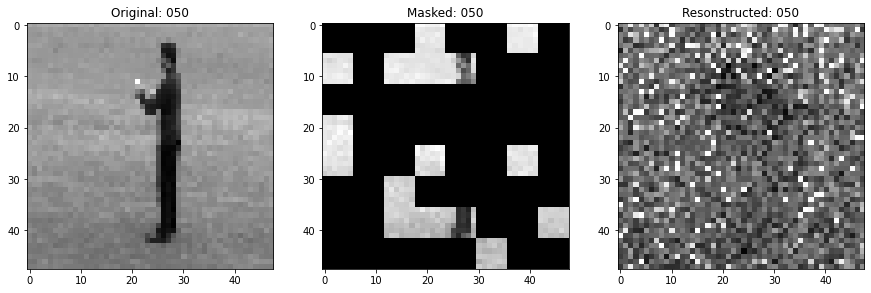

15/15 [==============================] - 30s 2s/step - loss: 0.0297 - mae: 0.1143 - val_loss: 0.0427 - val_mae: 0.1610
Epoch 52/500
15/15 [==============================] - 29s 2s/step - loss: 0.0294 - mae: 0.1136 - val_loss: 0.0426 - val_mae: 0.1607
Epoch 53/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0426 - val_mae: 0.1608
Epoch 54/500
15/15 [==============================] - 28s 2s/step - loss: 0.0298 - mae: 0.1142 - val_loss: 0.0426 - val_mae: 0.1605
Epoch 55/500
15/15 [==============================] - 29s 2s/step - loss: 0.0296 - mae: 0.1140 - val_loss: 0.0426 - val_mae: 0.1606
Epoch 56/500
15/15 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1136
Idx chosen: 202


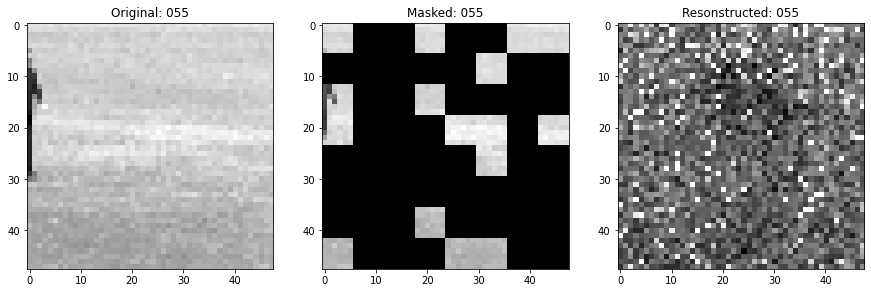

15/15 [==============================] - 32s 2s/step - loss: 0.0294 - mae: 0.1136 - val_loss: 0.0425 - val_mae: 0.1606
Epoch 57/500
15/15 [==============================] - 33s 2s/step - loss: 0.0299 - mae: 0.1143 - val_loss: 0.0425 - val_mae: 0.1602
Epoch 58/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1138 - val_loss: 0.0425 - val_mae: 0.1603
Epoch 59/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1140 - val_loss: 0.0424 - val_mae: 0.1600
Epoch 60/500
15/15 [==============================] - 29s 2s/step - loss: 0.0300 - mae: 0.1144 - val_loss: 0.0425 - val_mae: 0.1604
Epoch 61/500
15/15 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.1137
Idx chosen: 87


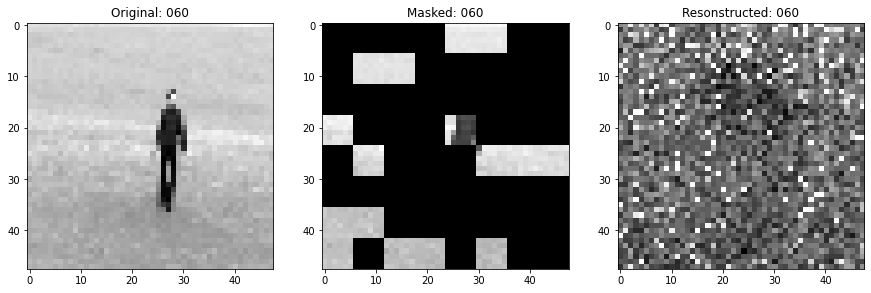

15/15 [==============================] - 30s 2s/step - loss: 0.0297 - mae: 0.1137 - val_loss: 0.0424 - val_mae: 0.1600
Epoch 62/500
15/15 [==============================] - 28s 2s/step - loss: 0.0300 - mae: 0.1145 - val_loss: 0.0424 - val_mae: 0.1599
Epoch 63/500
15/15 [==============================] - 28s 2s/step - loss: 0.0295 - mae: 0.1136 - val_loss: 0.0423 - val_mae: 0.1599
Epoch 64/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1140 - val_loss: 0.0423 - val_mae: 0.1598
Epoch 65/500
15/15 [==============================] - 28s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0422 - val_mae: 0.1596
Epoch 66/500
15/15 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.1134
Idx chosen: 116


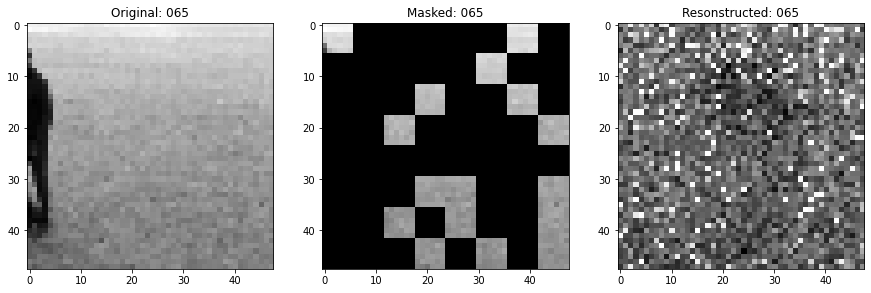

15/15 [==============================] - 29s 2s/step - loss: 0.0295 - mae: 0.1134 - val_loss: 0.0421 - val_mae: 0.1592
Epoch 67/500
15/15 [==============================] - 30s 2s/step - loss: 0.0295 - mae: 0.1136 - val_loss: 0.0422 - val_mae: 0.1594
Epoch 68/500
15/15 [==============================] - 31s 2s/step - loss: 0.0298 - mae: 0.1143 - val_loss: 0.0422 - val_mae: 0.1595
Epoch 69/500
15/15 [==============================] - 30s 2s/step - loss: 0.0298 - mae: 0.1140 - val_loss: 0.0421 - val_mae: 0.1591
Epoch 70/500
15/15 [==============================] - 30s 2s/step - loss: 0.0296 - mae: 0.1139 - val_loss: 0.0420 - val_mae: 0.1589
Epoch 71/500
15/15 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.1136
Idx chosen: 99


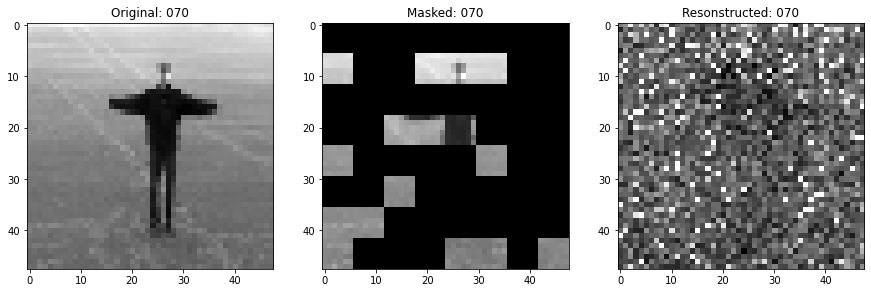

15/15 [==============================] - 29s 2s/step - loss: 0.0295 - mae: 0.1136 - val_loss: 0.0421 - val_mae: 0.1592
Epoch 72/500
15/15 [==============================] - 31s 2s/step - loss: 0.0298 - mae: 0.1141 - val_loss: 0.0420 - val_mae: 0.1589
Epoch 73/500
15/15 [==============================] - 28s 2s/step - loss: 0.0296 - mae: 0.1138 - val_loss: 0.0421 - val_mae: 0.1590
Epoch 74/500
15/15 [==============================] - 29s 2s/step - loss: 0.0297 - mae: 0.1141 - val_loss: 0.0420 - val_mae: 0.1587
Epoch 75/500
15/15 [==============================] - 29s 2s/step - loss: 0.0294 - mae: 0.1133 - val_loss: 0.0420 - val_mae: 0.1588
Epoch 76/500
12/15 [=======================>......] - ETA: 3s - loss: 0.0296 - mae: 0.1136

KeyboardInterrupt: 

In [21]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=scheduled_lrs
# )

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"],
    run_eagerly=True
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)